In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
data = pd.read_excel("C:\Mtech-thesis\Biomedical laboratory\Assn6 _BMP743.xlsx")
data.head

<bound method NDFrame.head of            X  Y
0       1.62  0
1       1.88  0
2       1.93  0
3       1.93  0
4       1.89  0
...      ... ..
195750  1.62  3
195751  1.63  3
195752  1.74  3
195753  1.64  3
195754  1.50  3

[195755 rows x 2 columns]>

In [3]:
X=data.iloc[:,0]
Y=data.iloc[:,1]

In [4]:
Sub1=data[data.iloc[:,1]==0]
Sub2=data[data.iloc[:,1]==1]
Sub3=data[data.iloc[:,1]==2]
Sub4=data[data.iloc[:,1]==3]

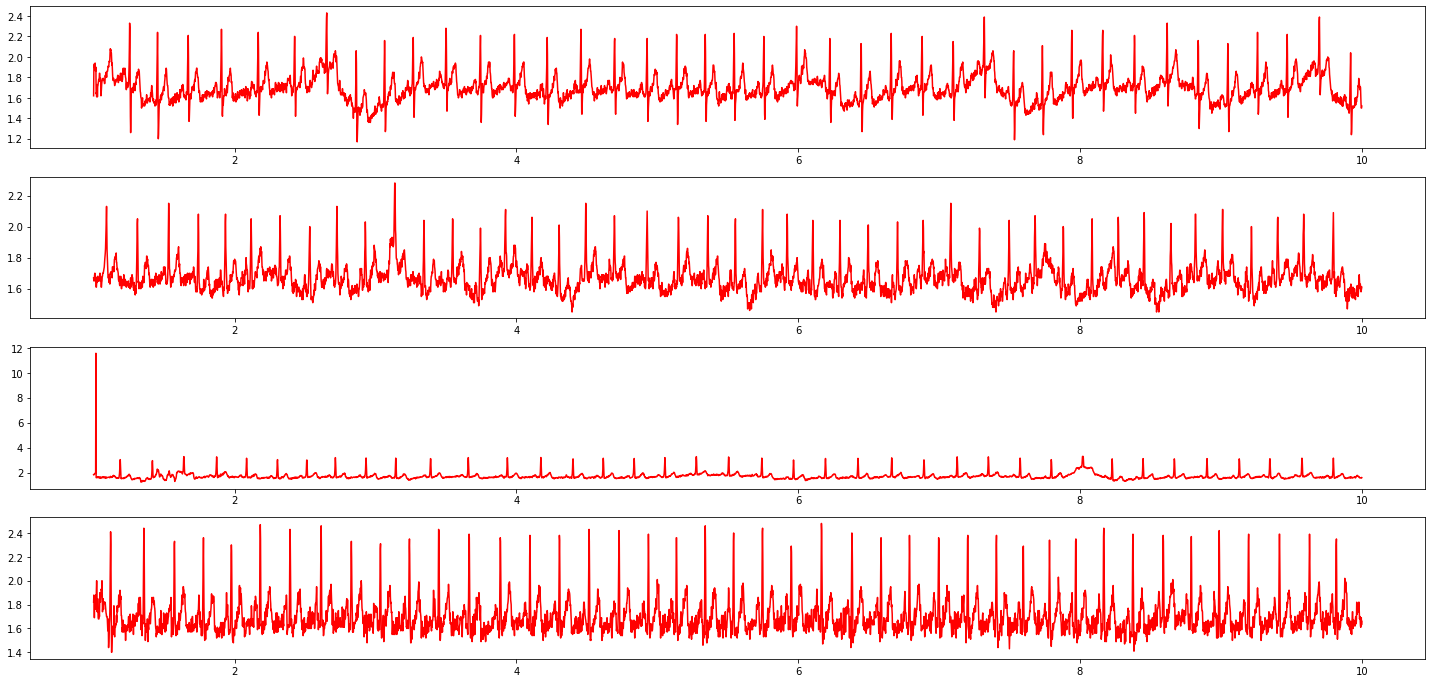

In [5]:
# plotting the ECG of four subjects
x=np.linspace(1,10,5000)
import matplotlib.pyplot as plt
plt.figure(figsize=(25,12))

plt.subplot(4,1,1)
plt.plot(x,Sub1.iloc[0:5000,0],'r-')

plt.subplot(4,1,2)
plt.plot(x,Sub2.iloc[0:5000,0],'r-')

plt.subplot(4,1,3)
plt.plot(x,Sub3.iloc[0:5000,0],'r-')

plt.subplot(4,1,4)
plt.plot(x,Sub4.iloc[0:5000,0],'r-')

There is one outlier in graph of subject three. Before starting analysis we have to remove this outlier.

In [6]:
# Removing an outlier from Subject 3
Sub3=Sub3[Sub3.iloc[:,0]<4]

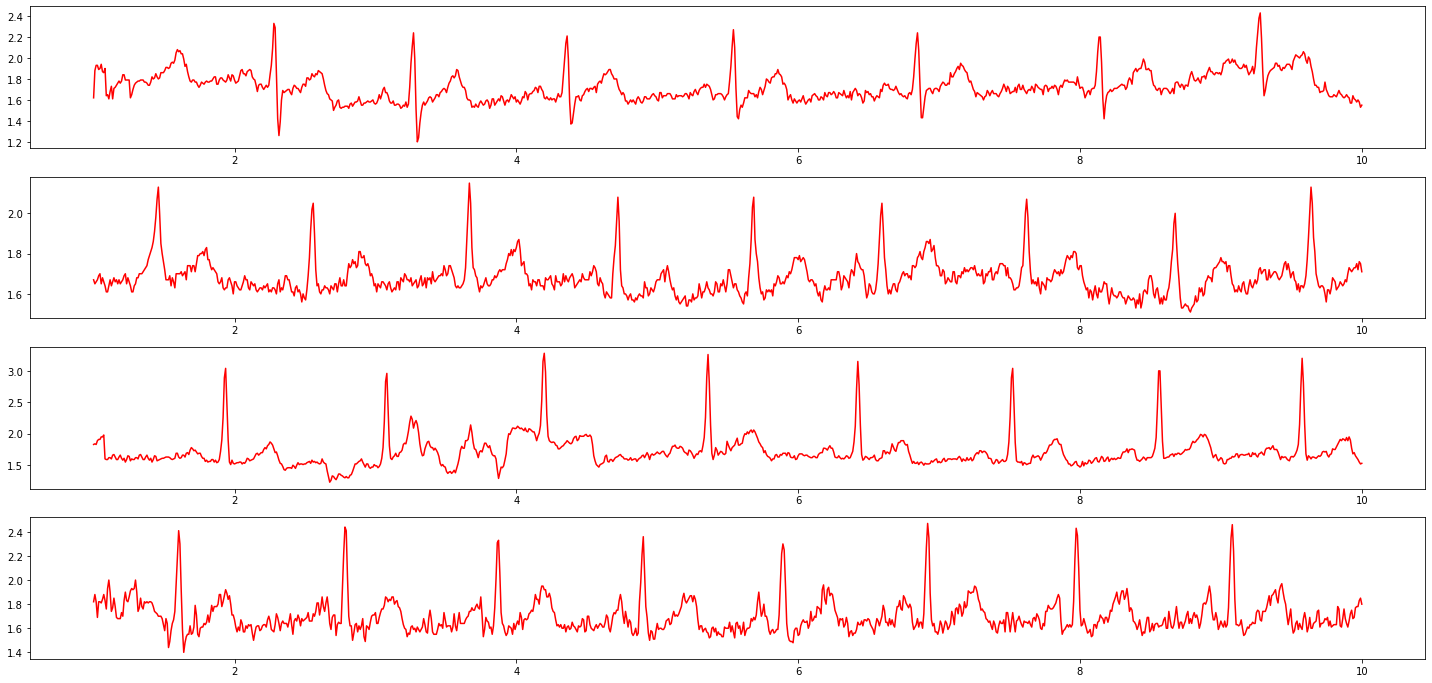

In [7]:
# Now again plotting graphs of ECG of all subjects
x=np.linspace(1,10,1000)
import matplotlib.pyplot as plt
plt.figure(figsize=(25,12))

plt.subplot(4,1,1)
plt.plot(x,Sub1.iloc[0:1000,0],'r-')

plt.subplot(4,1,2)
plt.plot(x,Sub2.iloc[0:1000,0],'r-')

plt.subplot(4,1,3)
plt.plot(x,Sub3.iloc[0:1000,0],'r-')

plt.subplot(4,1,4)
plt.plot(x,Sub4.iloc[0:1000,0],'r-')


### Preprocessing of ECG Data

### 1. Denoising of signal

In [8]:
from pywt import wavedec
import pywt

In [9]:
Signal=Sub1.iloc[0:5000,0]
y=np.linspace(1,10,5000)

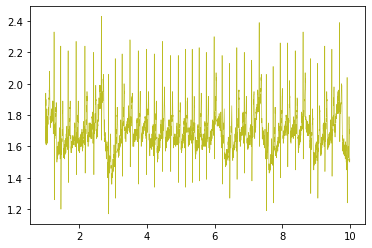

In [10]:
plt.plot(y,Signal,color='tab:olive', linewidth=0.6,label = 'input')

In [11]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  


signal_den1 = pd.DataFrame(denoise_signal(Sub1,'bior4.4', 9 , 1 , 7))
signal_den2 = pd.DataFrame(denoise_signal(Sub2,'bior4.4', 9 , 1 , 7)) #<--- trade off - the less the cutoff - the more R-peak morphology is lost
signal_den3 = pd.DataFrame(denoise_signal(Sub3,'bior4.4', 9 , 1 , 7))
signal_den4 = pd.DataFrame(denoise_signal(Sub4,'bior4.4', 9 , 1 , 7))

C:\Users\garga\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


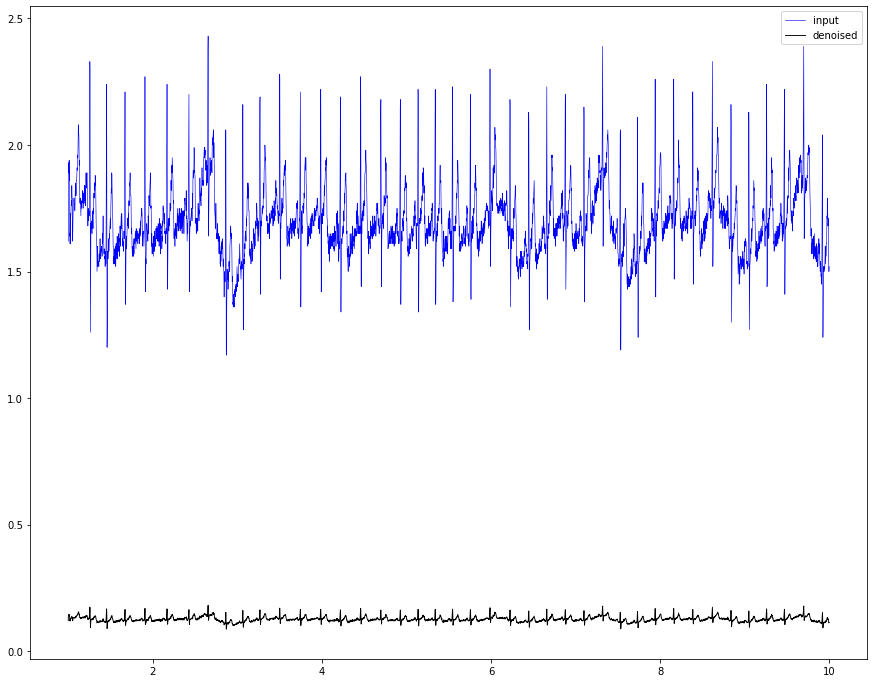

In [12]:
plt.figure(figsize=(15,12))
plt.plot(y,Signal, color='blue', linewidth=0.6,label = 'input')
plt.plot(y,signal_den1.iloc[0:5000,0], color='black', linewidth=0.9,label = 'denoised')
#plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

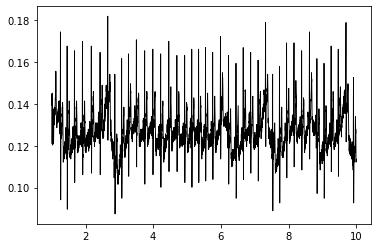

In [13]:
plt.plot(y,signal_den1.iloc[0:5000,0], color='black', linewidth=0.9,label = 'denoised')


### 2. Base line shift

In [14]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.signal import medfilt
import pywt
from pywt import wavedec
# >---------------------------------------------------------------------

# >------ parent db directory ------------------------------------------
#DATASET_DIR = '../input/shaoxing-and-ningbo-first-hospital-database/WFDB_ShaoxingUniv'
#print('DATASET DIR ::',DATASET_DIR)

# >------ global variables  ------------------------------------------
g_DATA = '.mat'
g_HEAD = '.hea'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6' ]
BASIC_SRATE = 500 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

Basic sampling rate(Hz): 500


In [ ]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res
# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(BASIC_SRATE,ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

signal_flt1 = filter_signal(signal_den1)
signal_flt2 = filter_signal(signal_den2)
signal_flt3 = filter_signal(signal_den3)
signal_flt4 = filter_signal(signal_den4)
plt.figure(figsize=(40,6))

plt.plot(np.arange(0,5000,1),signal_den1.iloc[0:5000,0], color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(signal_flt1.iloc[0:5000,0], color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_flt1, color='black', linewidth=0.9,label = 'filtered')
plt.fill_between(np.arange(0,5000,1),signal_den1.iloc[0:5000,0],signal_flt1.iloc[0:5000,0],color='tab:pink',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

C:\Users\garga\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


In [ ]:
signal_flt1.to_excel("C:\Mtech-thesis\Biomedical laboratory\SignalFilt1.xlsx")
signal_flt2.to_excel("C:\Mtech-thesis\Biomedical laboratory\SignalFilt2.xlsx")
signal_flt3.to_excel("C:\Mtech-thesis\Biomedical laboratory\SignalFilt3.xlsx")
signal_flt4.to_excel("C:\Mtech-thesis\Biomedical laboratory\SignalFilt4.xlsx")